In [1]:
import numpy as np
import numba as nb
from sklearn.datasets import load_digits
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
plt.style.use('seaborn-whitegrid')
rcParams['font.size'] = 18
rcParams['figure.figsize'] = (12, 8)

In [3]:
digits, digit_class = load_digits(return_X_y=True)
digits = np.ascontiguousarray(digits)
rand_idx = np.random.choice(np.arange(digits.shape[0]), size=500, replace=False)
data = digits[rand_idx,:].copy()
classes = digit_class[rand_idx]

In [4]:

EPSILON = 1e-12

@nb.jit(
    [nb.float64[:,:](nb.float64[:,:])],
    nopython=True,
    cache=True
)
def squared_dist_mat(X):
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return D

@nb.jit(
    [nb.float64[:,:](nb.float64[:,:], nb.float64[:,:], nb.float64[:,:])],
    nopython=True,
    cache=True
)
def pairwise_affinities(data, sigmas, dist_mat):
    """sigmas is mx1"""
    assert sigmas.shape == (data.shape[0], 1)
    inner = ((-dist_mat)/(2*(sigmas**2)))
    numers = np.exp(inner)
    denoms = np.sum(numers, axis=1) - np.diag(numers)
    denoms = denoms.reshape(-1, 1)
    denoms += 1e-12 # Avoid div/0
    P = numers/denoms
    np.fill_diagonal(P, 0.)
    return P

@nb.jit(
    [nb.float64[:](nb.float64[:,:])],
    nopython=True,
    cache=True
)
def get_entropies(asym_affinities):
    """
    Row-wise Shannon entropy of pairwise affinity matrix P
    """
    asym_affinities += EPSILON
    return - np.sum(asym_affinities * np.log2(asym_affinities), axis=1)


@nb.jit(
    [nb.float64[:](nb.float64[:,:])],
    nopython=True,
    cache=True
)
def get_perplexities(asym_affinities):
    return 2**get_entropies(asym_affinities)
    

@nb.jit(
    [nb.float64[:,:](nb.float64[:,:], nb.float64, nb.float64, nb.int16)],
    nopython=False,
    cache=True
)
def all_sym_affinities(data, perp, tol, attempts=100):
    """
    Returns sigma and pji affinities for a specific value of i which
    corresponds to perp, the desired perplexity.
    
    Output Shape: Sigma is scalar, pji is 1xm asym affinities
    """
    dist_mat = squared_dist_mat(data) # mxm
    
    sigma_maxs = np.full(data.shape[0], 1e12)

    # zero here causes div/0, /2sigma**2 in P calc
    sigma_mins = np.full(data.shape[0], 1e-12)

    current_perps = np.full(data.shape[0], np.inf)
    
    while (not np.allclose(current_perps, perp, atol=tol)) and attempts>0:
        sigmas = (sigma_mins + sigma_maxs) / 2
        P = pairwise_affinities(data, sigmas.reshape(-1,1), dist_mat)
        current_perps = get_perplexities(P)
        attempts-=1
        for i in range(len(current_perps)):
            current_perp = current_perps[i]
            if current_perp > perp:
                sigma_maxs[i] = sigmas[i]
            elif current_perp < perp:
                sigma_mins[i] = sigmas[i]
            
    if attempts == 0:
        print("Warning: Ran out attempts before converging, try a different perplexity?")
    P = (P + P.T) / (2*data.shape[0])
    return P

@nb.jit(
    [nb.float64[:,:](nb.float64[:,:], nb.float64[:,:])],
    nopython=True,
    cache=True
)
def low_dim_affinities(Y, Y_dist_mat):
    numers = (1 + Y_dist_mat) ** (-1)
    denom = np.sum(numers) - np.sum(np.diag(numers))
    denom += 1e-12 # Avoid div/0
    Q = numers/denom
    np.fill_diagonal(Q, 0.)
    return Q


@nb.jit(
    [nb.float64[:,:](nb.float64[:,:], nb.float64[:,:], nb.float64[:,:], nb.float64[:,:])],
    nopython=False,
    cache=True
)
def compute_grad(P, Q, Y, Y_dist_mat):
    Ydiff = (Y[:, np.newaxis, :] - Y[np.newaxis, :, :])
    pq_factor = (P-Q)[:, :, np.newaxis]
    dist_factor = ((1+Y_dist_mat)**(-1))[:, :, np.newaxis]
    return np.sum(4*pq_factor*Ydiff*dist_factor, axis=1) 
   

In [5]:
def tsne(data, n_components, perp, n_iter, lr, momentum_fn, perp_tol=1e-8, pbar=False, random_state=None):
    rand = np.random.RandomState(random_state)
    
    P = all_sym_affinities(data, perp, perp_tol)
    #P = np.clip(P, 1e-12, None)

    init_mean = np.zeros(n_components)
    init_cov = np.identity(n_components) * 1e-4
    
    Y = rand.multivariate_normal(mean=init_mean, cov=init_cov, size=data.shape[0])
    
    Y_old = np.zeros_like(Y)
    
    iter_range = range(n_iter)
    if pbar:
        iter_range = tqdm(iter_range, "Iterations")
    for t in iter_range:
        Y_dist_mat = squared_dist_mat(Y)
        Q = low_dim_affinities(Y, Y_dist_mat)
        #Q = np.clip(Q, 1e-12, None)
        grad = compute_grad(P, Q, Y, Y_dist_mat)
        Y = Y - lr*grad + momentum_fn(t)*(Y - Y_old)# Add momentum
        Y_old = Y.copy()
        
    return Y

In [6]:
def momentum_func(t):
    if t< 250:
        return .5
    else:
        return .8

In [7]:
%%time
low_dim = tsne(digits, 2, 30, 500, 100, momentum_func, pbar=True, random_state = 42)

Iterations:   0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 6min 59s, sys: 1min 28s, total: 8min 28s
Wall time: 1min 36s


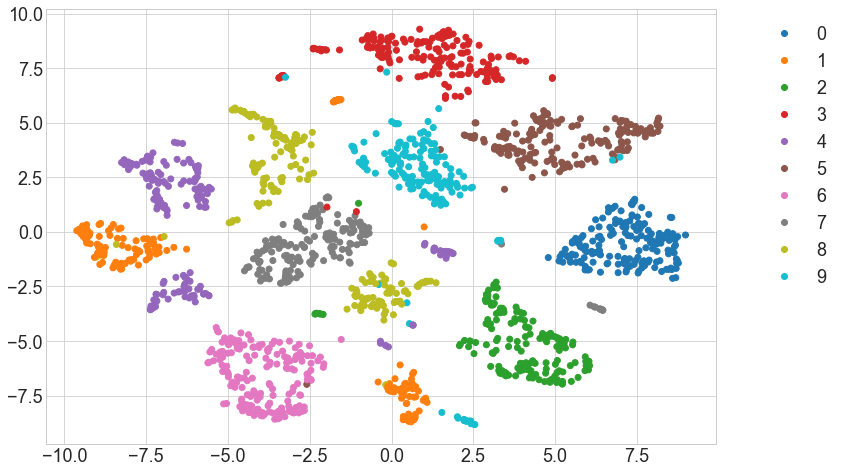

In [8]:
scatter = plt.scatter(low_dim[:,0], low_dim[:,1], cmap='tab10', c=digit_class)
plt.legend(*scatter.legend_elements(), fancybox=True, bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
%%timeit -n3 -r3
low_dim = tsne(data, 2, 30, 100, 100, momentum_func, random_state = 42)